# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from transformers import BertConfig
from transformers import RobertaTokenizerFast

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

sys.path.append("../../../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
sequence_len = 512
batch_size = 64

config = BertConfig(
    vocab_size=9,
    hidden_size=84,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=2
)

epochs = 10

# Load & Prepare the data

In [4]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_test = all_data["simple_terms"].tolist()
# RI has fewer steps -> 1
# Otherwise 0
y_test = [1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count TESTING samples: {len(y_test)}")

Count all terms: 4251

Count original terms: 4251

max RI steps count: 1000
max LO steps count: 219
Count TESTING samples: 4251


In [31]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str_extended.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_train = all_data["simple_terms"].tolist()
# RI has fewer steps -> 1
# Otherwise 0
y_train = [1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count TRAINING samples: {len(y_train)}")

Count all terms: 44568

Count original terms: 44568

max RI steps count: 1000
max LO steps count: 1000
Count TRAINING samples: 44568


In [32]:
counter = Counter(y_test)
print(f"Test Distribution: {counter}")
counter = Counter(y_train)
print(f"Test Distribution: {counter}")

Test Distribution: Counter({0: 3872, 1: 379})
Test Distribution: Counter({0: 39336, 1: 5232})


In [7]:
tokenizer = RobertaTokenizerFast.from_pretrained("../../transformers_to_lo_steps_prediciton/fine_models", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
x_train = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_train]
x_test = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_test]

train_df = pd.DataFrame({"term_str": x_train, "is_ri_best": y_train})
test_df = pd.DataFrame({"term_str": x_test, "is_ri_best": y_test})

In [9]:
train_df_to_copy = train_df[train_df["is_ri_best"] == 1].reset_index(drop=True)
len(train_df_to_copy)
train_df_to_copy = pd.concat([train_df_to_copy, train_df_to_copy, train_df_to_copy, train_df_to_copy, train_df_to_copy, train_df_to_copy, train_df_to_copy], ignore_index=True).reset_index(drop=True)
len(train_df_to_copy)

36624

In [34]:
train_df = pd.concat([train_df, train_df_to_copy], ignore_index=True).reset_index(drop=True)

NameError: name 'train_df_to_copy' is not defined

In [35]:
len(train_df)

44568

In [36]:
def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor(example["is_ri_best"])
    return tokenized_texts, labels


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

In [14]:
del train_df
del test_df
del train_df_to_copy
del tokenized_train_data
del tokenized_test_data

# Define the model

In [15]:
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=1, activation="sigmoid")(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  130832      ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [17]:
model_structure = model.to_json()
with open("./fine_models/transformer_model_balanced.json", 'w') as json_file:
    json_file.write(model_structure)

In [18]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/transformer_model_balanced.h5',  # Specify the path to save the best model
    monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [19]:
# class_weights = {
#     0: 0.5,
#     1: 0.5,
# }
# history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1, callbacks=[checkpoint_callback], class_weight=class_weights)

history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/10
1269/1269 [==============================] - 212s 164ms/step - loss: 0.1950 - accuracy: 0.9338 - precision: 0.9987 - recall: 0.8728 - val_loss: 12.9490 - val_accuracy: 0.0892 - val_precision: 0.0892 - val_recall: 1.0000
Epoch 2/10
1269/1269 [==============================] - 205s 162ms/step - loss: 0.2419 - accuracy: 0.9288 - precision: 0.9925 - recall: 0.8685 - val_loss: 11.4131 - val_accuracy: 0.0892 - val_precision: 0.0892 - val_recall: 1.0000
Epoch 3/10
1269/1269 [==============================] - 198s 156ms/step - loss: 0.2357 - accuracy: 0.9306 - precision: 0.9935 - recall: 0.8712 - val_loss: 13.2445 - val_accuracy: 0.0892 - val_precision: 0.0892 - val_recall: 1.0000
Epoch 4/10
1269/1269 [==============================] - 200s 158ms/step - loss: 0.2571 - accuracy: 0.9279 - precision: 0.9861 - recall: 0.8724 - val_loss: 16.2245 - val_accuracy: 0.0892 - val_precision: 0.0892 - val_recall: 1.0000
Epoch 5/10
1269/1269 [==============================] - 203s 160ms/step - lo

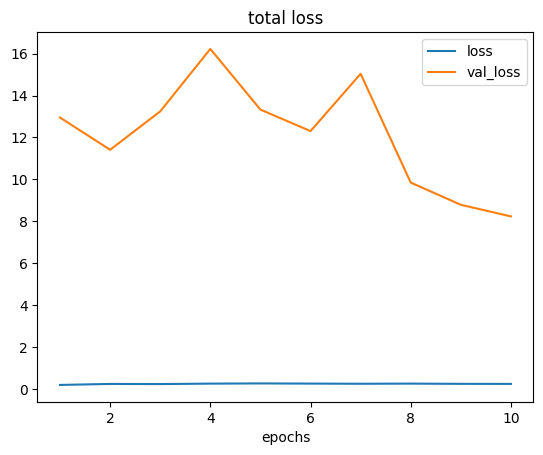

In [20]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

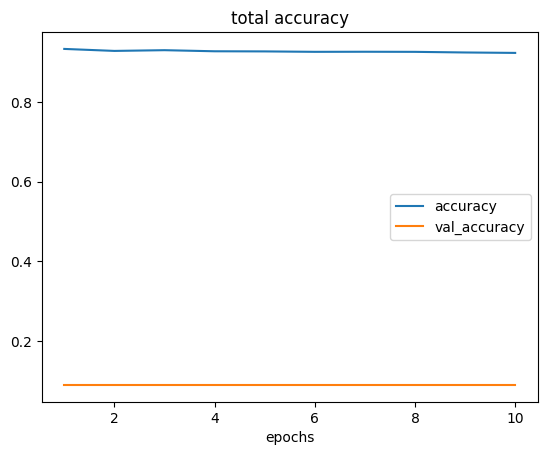

In [21]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

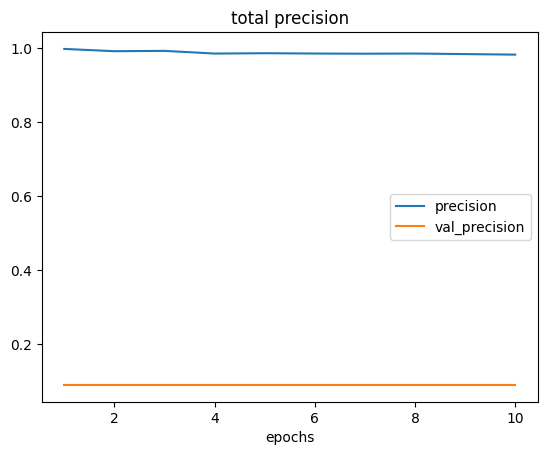

In [22]:
plt.plot(range(1, epochs + 1), history.history['precision'], label="precision")
plt.plot(range(1, epochs + 1), history.history['val_precision'], label="val_precision")
plt.xlabel("epochs")
plt.title("total precision")

plt.legend()
plt.show()

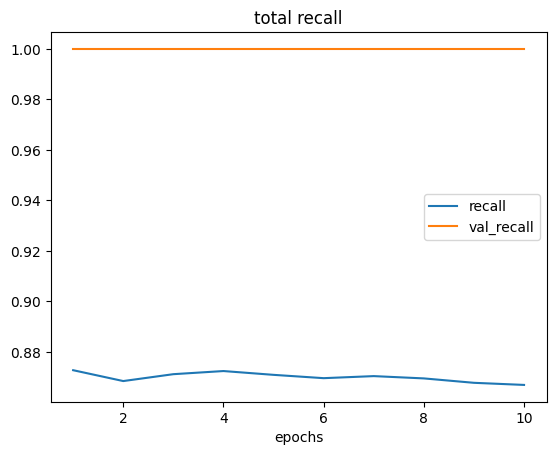

In [23]:
plt.plot(range(1, epochs + 1), history.history['recall'], label="recall")
plt.plot(range(1, epochs + 1), history.history['val_recall'], label="val_recall")
plt.xlabel("epochs")
plt.title("total recall")

plt.legend()
plt.show()

In [24]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, class_labels, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix of a classification model.

    Args:
        y_true (numpy.ndarray): The ground truth labels.
        y_pred (numpy.ndarray): The predicted labels.
        classes (list): The list of class labels.
        class_labels: The list of class names.
        normalize (bool, optional): Whether to normalize the confusion matrix. Defaults to False.
        title (str, optional): The title of the plot. Defaults to None.
        cmap (matplotlib.colors.Colormap, optional): The colormap to use for the plot. Defaults to plt.cm.Blues.
    """

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize:
        cm = confusion_matrix(y_true, y_pred, labels=classes).astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(title)
    fig.colorbar(im)

    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            ij = float(cm[i, j])
            ax.text(j, i, f"{ij:.2f}", ha='center', va='center', color='white' if ij > thresh else 'black')

    plt.tight_layout()
    plt.show()

In [25]:
# load the model
from transformers import TFBertModel

with open("./fine_models/transformer_model_balanced.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={"TFBertModel": TFBertModel})
model.load_weights("./fine_models/transformer_model_balanced.h5")

In [38]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = y_test
y_train_nums = y_train

697/697 [==============================] - 40s 57ms/step


Test accuracy: 0.08915549282521759


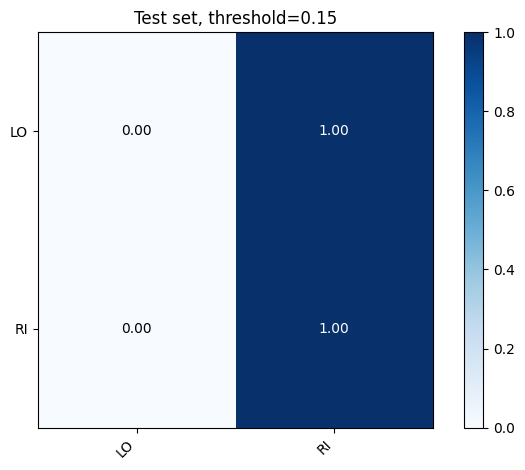

Train accuracy: 0.11739364566505116


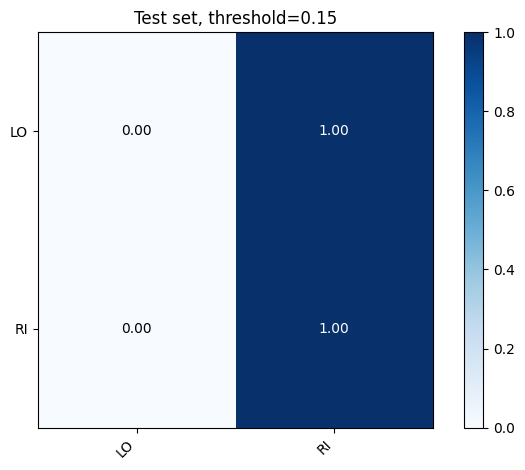

In [39]:
THRESHOLD = 0.15

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.08915549282521759


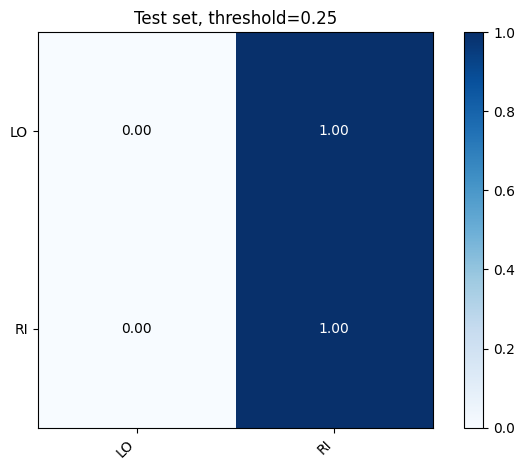

Train accuracy: 0.11739364566505116


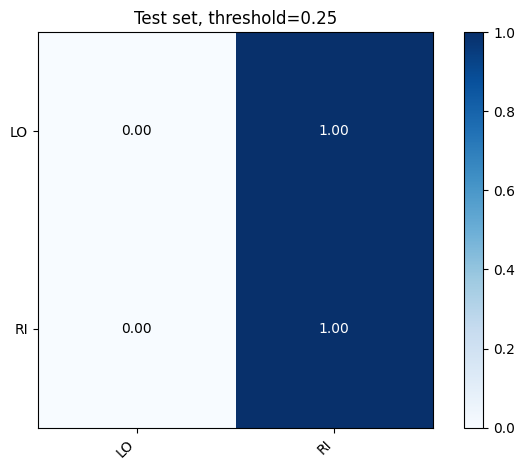

In [40]:
THRESHOLD = 0.25

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.08915549282521759


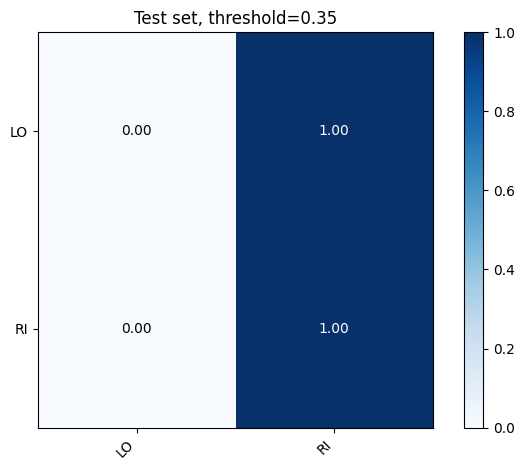

Train accuracy: 0.11739364566505116


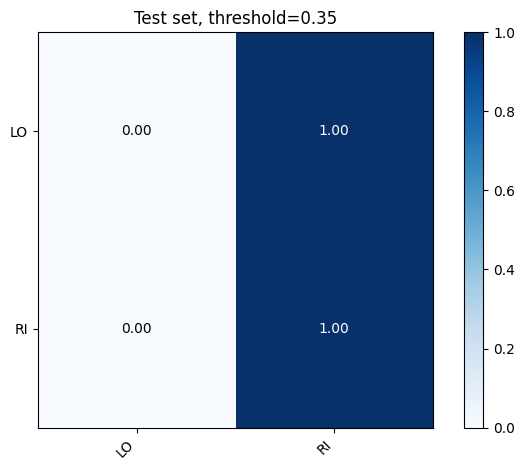

In [41]:
THRESHOLD = 0.35

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.08915549282521759


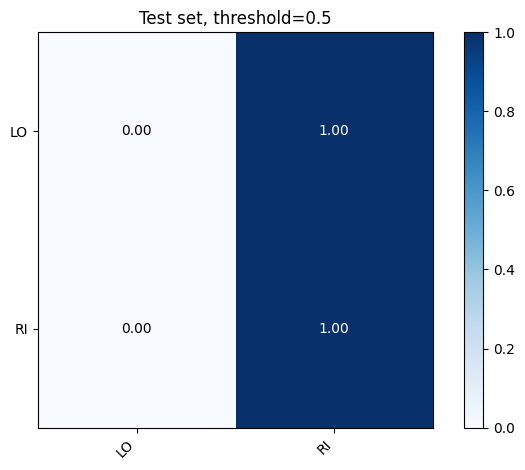

Train accuracy: 0.11739364566505116


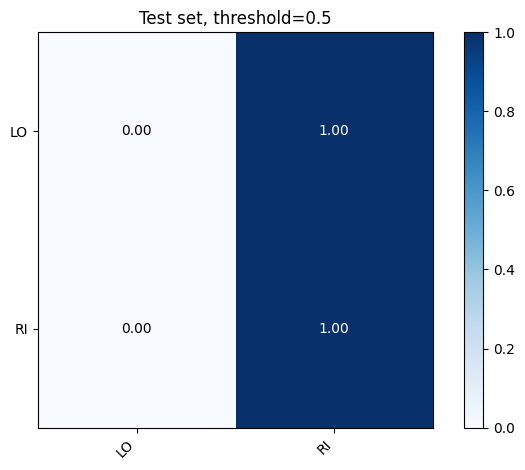

In [42]:
THRESHOLD = 0.5

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

In [43]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    simple_str = term.simple_str()
    simple_str = simple_str.replace("@x.", "y").replace(" ", "")

    tokenized_texts = tokenizer([simple_str], truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")

    prediction_ = model_.predict([tokenized_texts["input_ids"], tokenized_texts["attention_mask"]], verbose=0)

    los = term_.normalize(LOStrategy())[1]
    ris = term_.normalize(RIStrategy())[1]
    res_real =  2 if los == ris else 1 if los > ris else 0
    class_labels = ["LO", "RI", "LO == RI"]
    print(f"{term_deskr_}\nbest real -> {class_labels[res_real]}\tRI best prob = {prediction_[0]}\n")


list_test_functions = (
term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10,
term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
best real -> LO	RI best prob = [0.9999988]

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
best real -> LO == RI	RI best prob = [0.99999917]

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
best real -> LO == RI	RI best prob = [0.99999917]

(PRED 0) == 0 == λx. λy. y
best real -> LO == RI	RI best prob = [0.99999905]

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
best real -> LO == RI	RI best prob = [0.9999993]

(PLUS 0 0) == 0 == λx. λy. y
best real -> LO == RI	RI best prob = [0.99999905]

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
best real -> LO == RI	RI best prob = [0.9999993]

(SUBTRACT 3 5) == 0 == λx. λy. y
best real -> LO == RI	RI best prob = [0.9999995]

(LEQ 3 2) == FALSE == λx. λy. y
best real -> LO	RI best prob = [0.9999995]

(LEQ 2 5) == TRUE == λx. λy. x
best real -> LO == RI	RI best prob = [0.9999995]

(EQ 2 2) == TRUE == λx. λy. x
best real -> LO	RI best prob = [0.9999993]

(EQ 1 4) == FALSE == λx. λy. y
best real -> 